In [3]:
import sys
# your source folder
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [4]:
from src.modules import conf, fit, evl, preprocess, compare, compare_features
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor, XGBRFRegressor
warnings.simplefilter("ignore")
from feature_engine.creation import MathFeatures
import pickle
from datetime import datetime, timedelta

/home/zahradnik/PycharmProjects/master_thesis/src/modules/__init__.py
/home/zahradnik/PycharmProjects/master_thesis


In [5]:
next_day = f"{(datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')}-11-30"

In [6]:
best_params_hr = {"learning_rate": 0.069, "max_depth": 2, "min_child_weight":1.23}
best_params_cad = {"learning_rate": 0.146, "max_depth": 8, "min_child_weight":4.06}
best_params_speed = {"learning_rate": 0.137, "max_depth": 2, "min_child_weight": 2.40}

In [11]:
name_of_the_race = "bechovice.gpx"

In [7]:
data = fit.load_pcls(
        'zahradnik',
        'running',
        conf["Paths"]["pcl"],
        datetime.strptime(next_day, "%Y-%m-%d-%H-%M")
    )

100%|██████████| 386/386 [00:01<00:00, 236.13it/s]


In [9]:
low_dist, high_dist = preprocess.segment_data(data)

In [12]:
test_df = preprocess.load_test_activity(path=f"tracks/{name_of_the_race}",
                                        race_day =next_day)

In [13]:
if max(test_df.distance) > 10000:
    train_df = fit.clean_data(pd.concat(high_dist))
else:
    train_df = fit.clean_data(pd.concat(low_dist))
len(train_df)

681291

In [ ]:
clf = XGBRegressor(best_params_cad)
clf.fit(train_df[test_df.columns], train_df.cadence)
test_df['cadence'] = clf.predict(test_df)
test_df['cadence'].mean()

In [18]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

In [19]:
clf = XGBRegressor(best_params_hr)
clf.fit(train_df[test_df.columns], train_df.heart_rate)
test_df["heart_rate"] = clf.predict(test_df)
test_df["heart_rate"].mean()

177.81383

In [20]:
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)

In [21]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

In [22]:
clf = XGBRegressor(best_params_speed)
clf.fit(train_df[test_df.columns], train_df.enhanced_speed)
cols_in_model = test_df.columns
test_df["enhanced_speed"] = clf.predict(test_df)

In [ ]:
percent_delay = int(len(test_df) * 0.02)  ## 2% delay

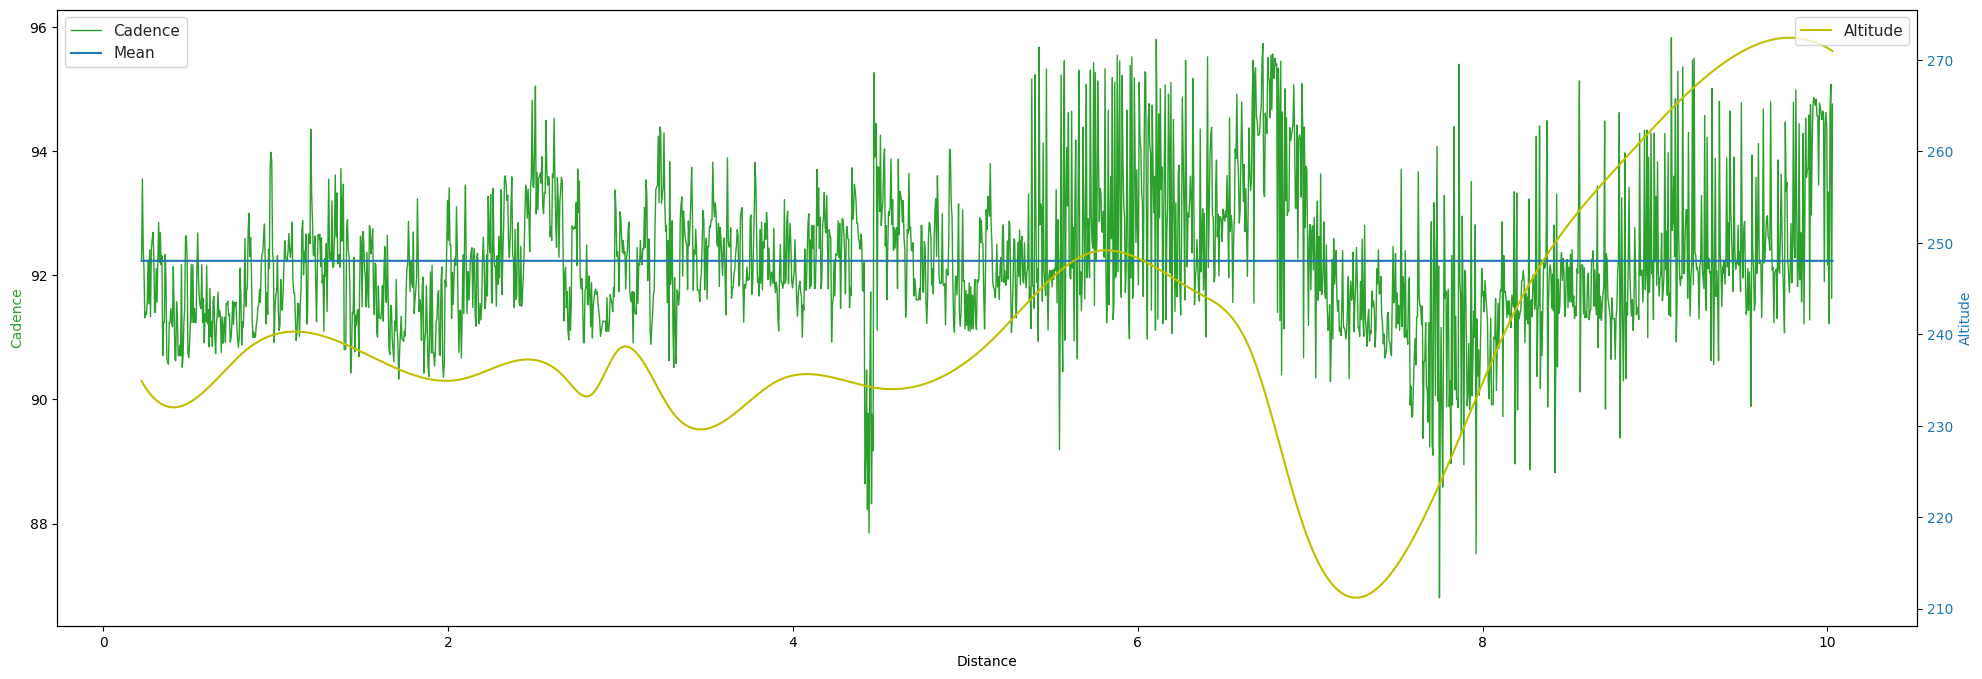

In [25]:
cad_plot = evl.plot(df=test_df[percent_delay:], pred=test_df['cadence'][percent_delay:], ylabel="Cadence", color="green")

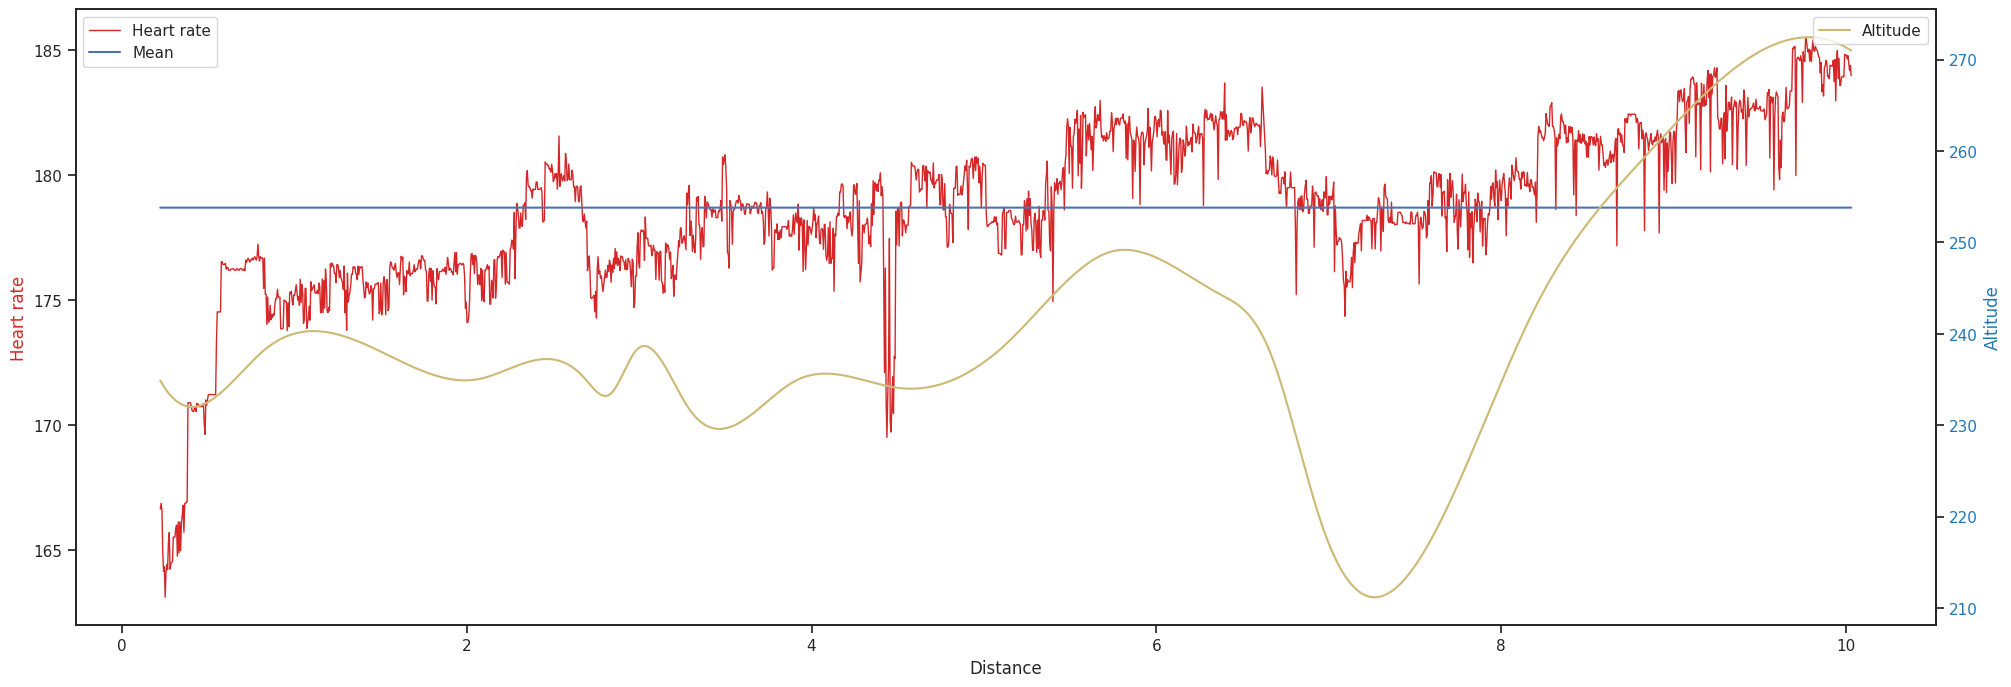

In [26]:
hr_plot = evl.plot(df=test_df[percent_delay:],pred=test_df['heart_rate'][percent_delay:],ylabel="Heart rate", color="red")

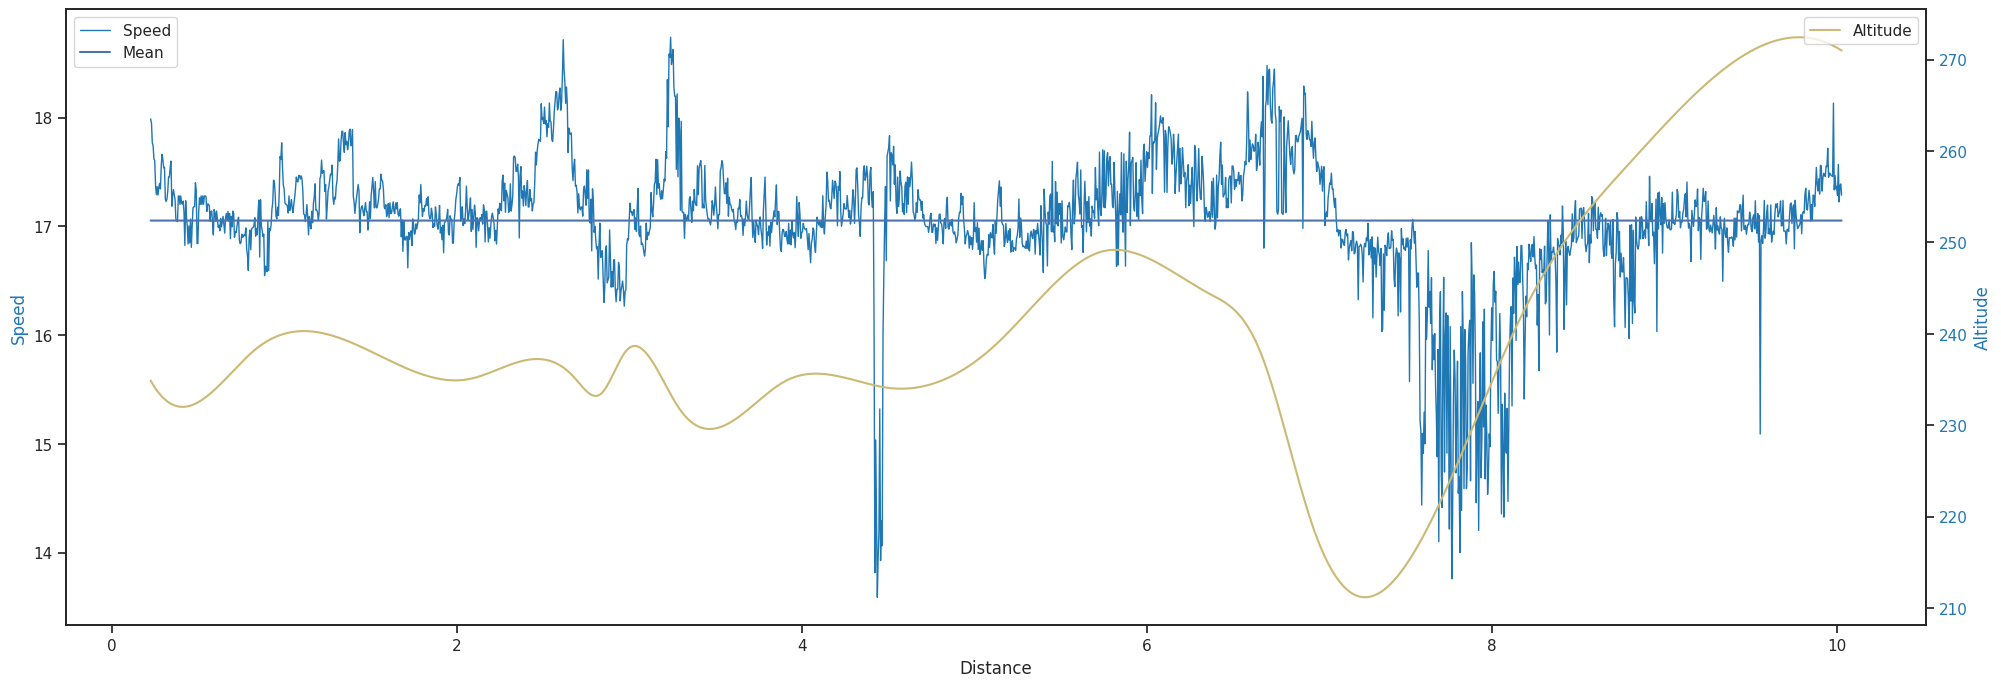

In [27]:
speed_plot = evl.plot(df=test_df[percent_delay:],pred=test_df["enhanced_speed"][percent_delay:],bylabel="Speed", color="blue")

In [ ]:
import math

# np.mean(speed_test), np.mean(y_pred_ridge), max(test_df.distance)
time = ((np.max(test_df.distance) / 1000) / np.mean(test_df["enhanced_speed"])) * 60
minutes = math.floor(time)
seconds = round((time - minutes) * 60)
if seconds == 60:
    seconds = 0
    minutes += 1
final_time = f'Final time: {minutes}:{seconds}'
f'Final time: {minutes}:{seconds}'

In [35]:
hradec = preprocess.load_test_activity(path="tracks/hradec_half.gpx",
                                        race_day ='2023-11-13-11-30')
fit.get_final_df(train_df=train_df,
                 test_df=hradec,
                 model=XGBRegressor(),
                 race_name="hradec",
                 athlete_name="zahradnik")

'74:58'

In [36]:
silvestrak = preprocess.load_test_activity(path="tracks/silvestrak.gpx",
                                        race_day ='2023-11-10-11-00')
fit.get_final_df(train_df=train_df,
                 test_df=silvestrak,
                 model=XGBRegressor(),
                 race_name="silvestrak",
                 athlete_name="zahradnik")

'17:50'

In [37]:
boston = preprocess.load_test_activity(path="tracks/boston.gpx",
                                        race_day ='2023-11-12-11-00')
fit.get_final_df(train_df=train_df,
                 test_df=boston,
                 model=XGBRegressor(),
                 race_name="boston",
                 athlete_name="zahradnik")

'146:23'

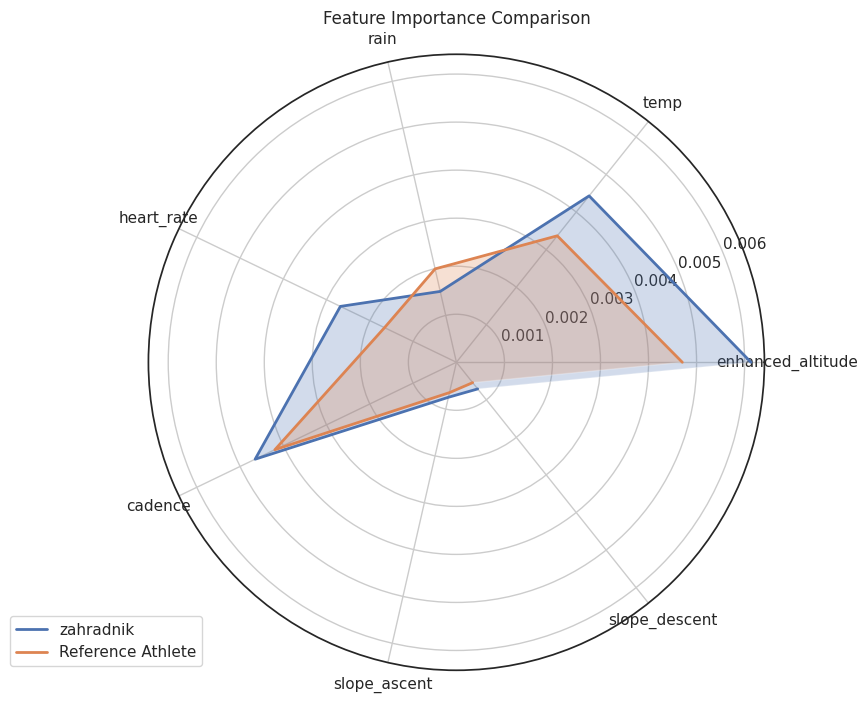

In [38]:
from src.modules.compare import Compare

compare = Compare(ref_athlete_name="zimola")
compare.calc_importances(cols=test_df.columns, clf=clf)
radar= compare.plot_radar()

In [39]:
from src.modules import ui_output
ui_output.gen_map(track_name="bechovice")

LOG: HTML page with the plots next to each other has been created.


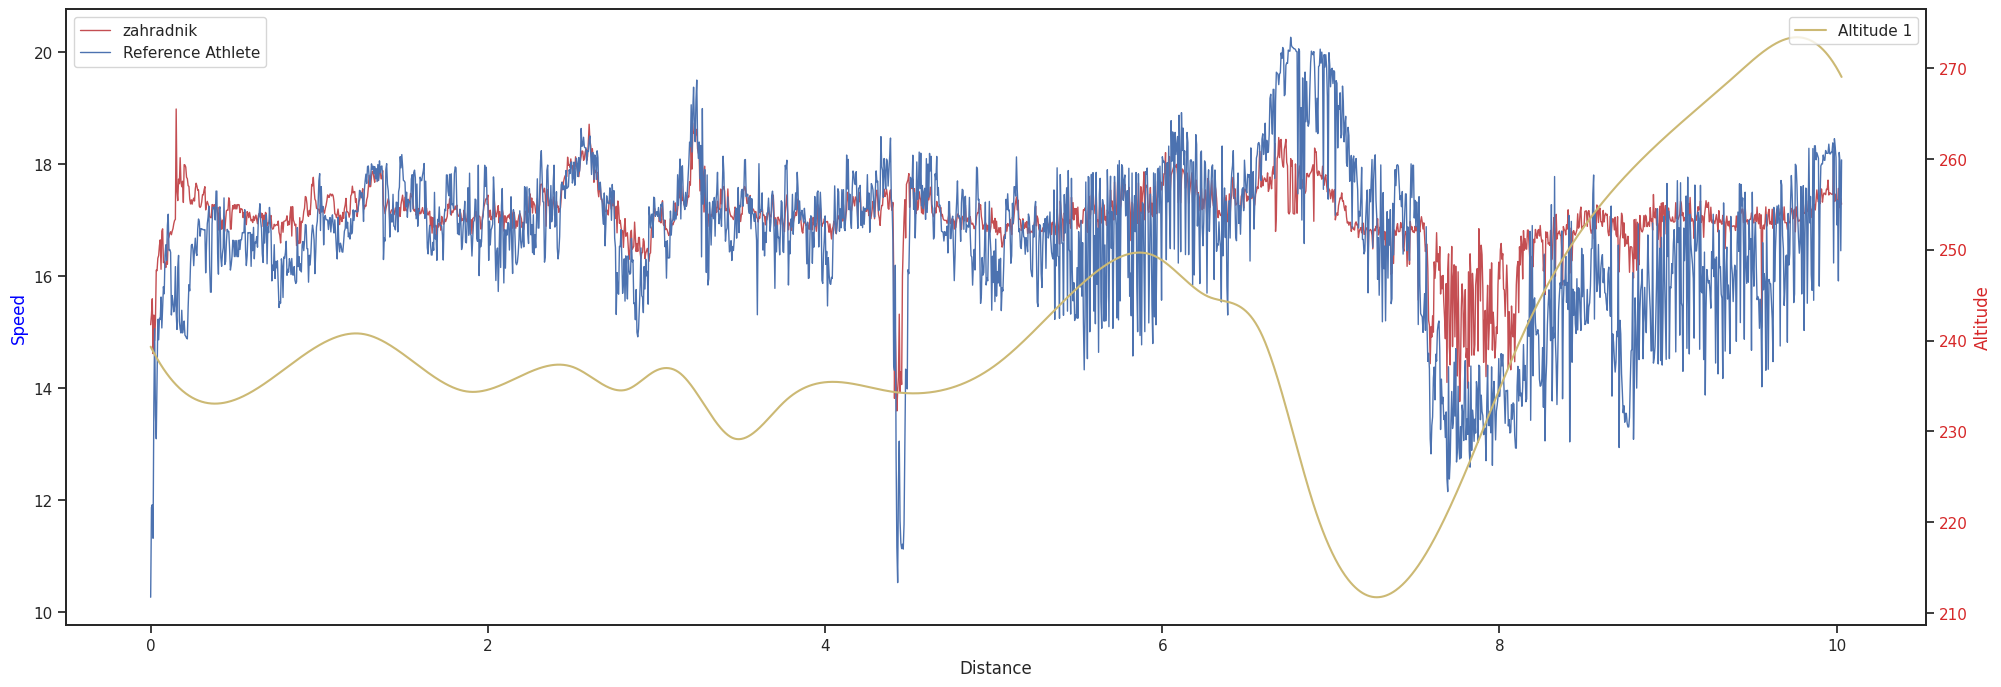

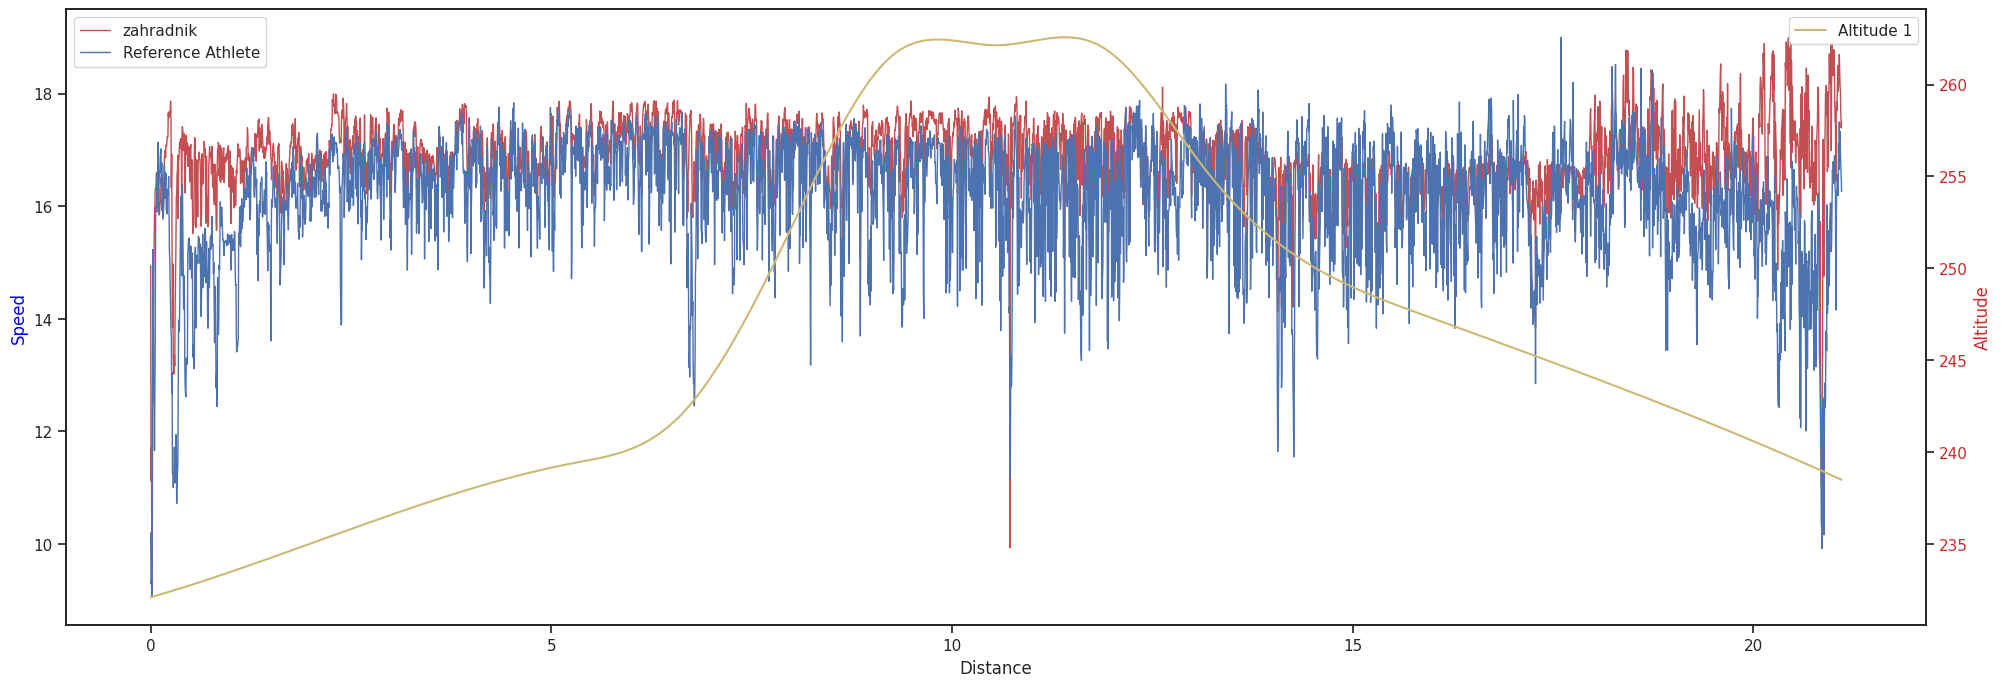

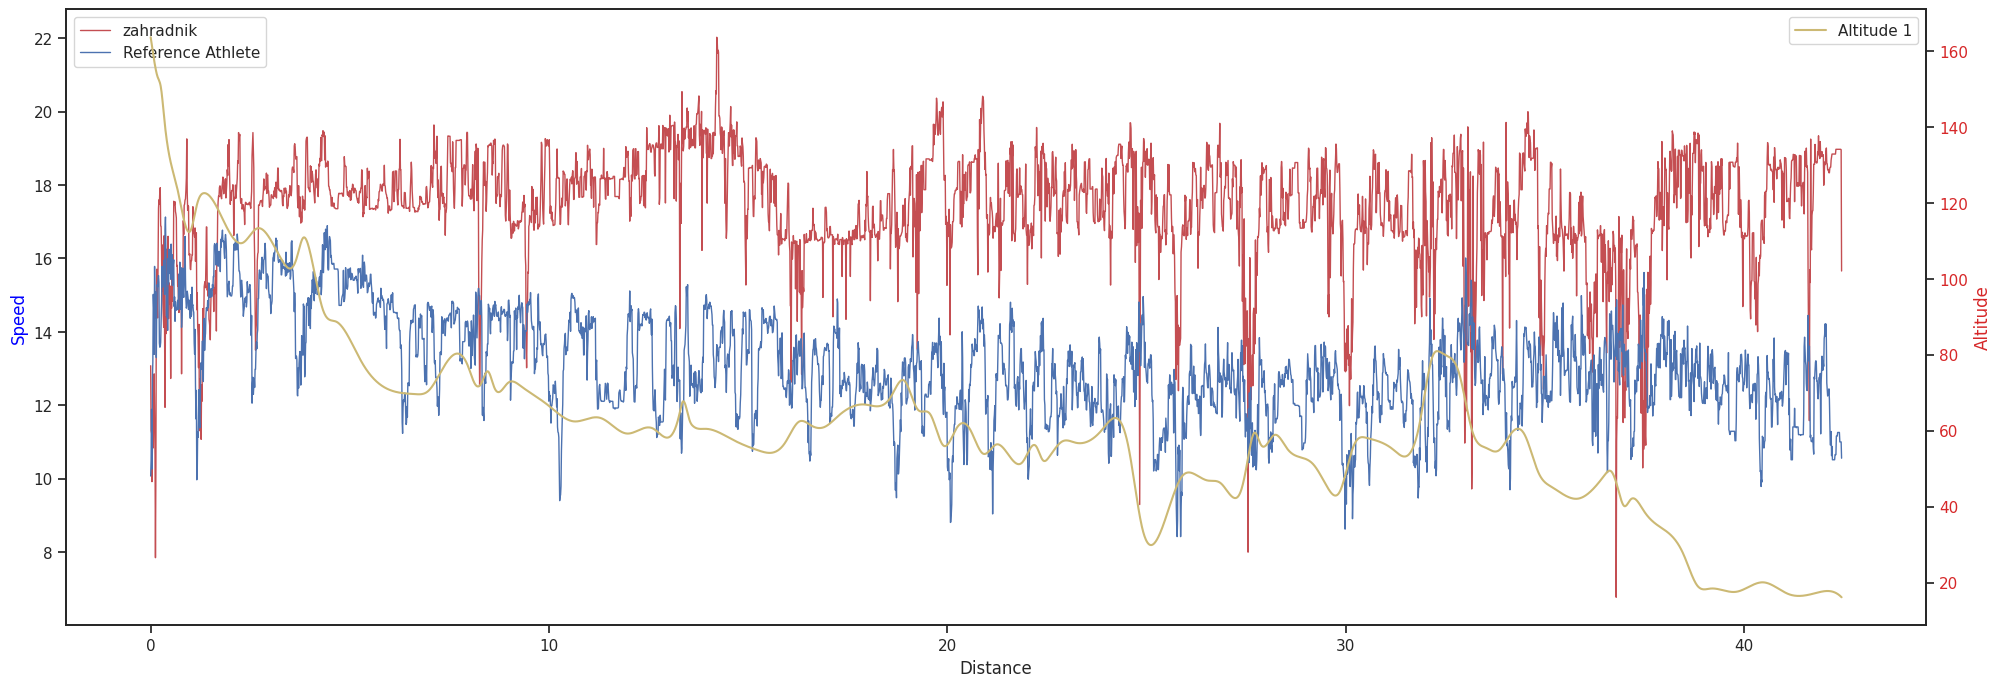

In [49]:
ui_output.save_report(athlete_name=conf["Athlete"]["name"],
                      activity_name="bechovice.gpx"
                      .replace(".gpx","")
                      .capitalize(),
                      cad_plot=cad_plot,
                      hr_plot=hr_plot,
                      speed_plot=speed_plot,
                      final_time=final_time,
                      df=test_df,
                      radar_plot = radar,
                      track_name="bechovice"
                      )